In [1]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

d:\OmniParse\omni_venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
d:\OmniParse\omni_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Error reading from C:\Users\avpaul\AppData\Roaming\Ultralytics\settings.json: "No Ultralytics setting 'openvino_msg'. \nView Ultralytics Settings with 'yolo settings' or at 'C:\\Users\\avpaul\\AppData\\Roaming\\Ultralytics\\settings.json'\nUpdate Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings."
Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\avpaul\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
model to cuda


In [2]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [5]:
# reload utils
import importlib
import utils
importlib.reload(utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

# image_path = 'imgs/google_page.png'
# image_path = 'imgs/windows_home.png'
# # image_path = 'imgs/windows_multitab.png'
# # image_path = 'imgs/omni3.jpg'
# # image_path = 'imgs/ios.png'
# image_path = 'imgs/word.png'
# # image_path = 'imgs/excel2.png'

image_path = "hysys_test_ts.png"

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1920, 1080)

0: 736x1280 157 icons, 70.9ms
Speed: 7.0ms preprocess, 70.9ms inference, 164.5ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 187 107
time to get parsed content: 0.6905808448791504


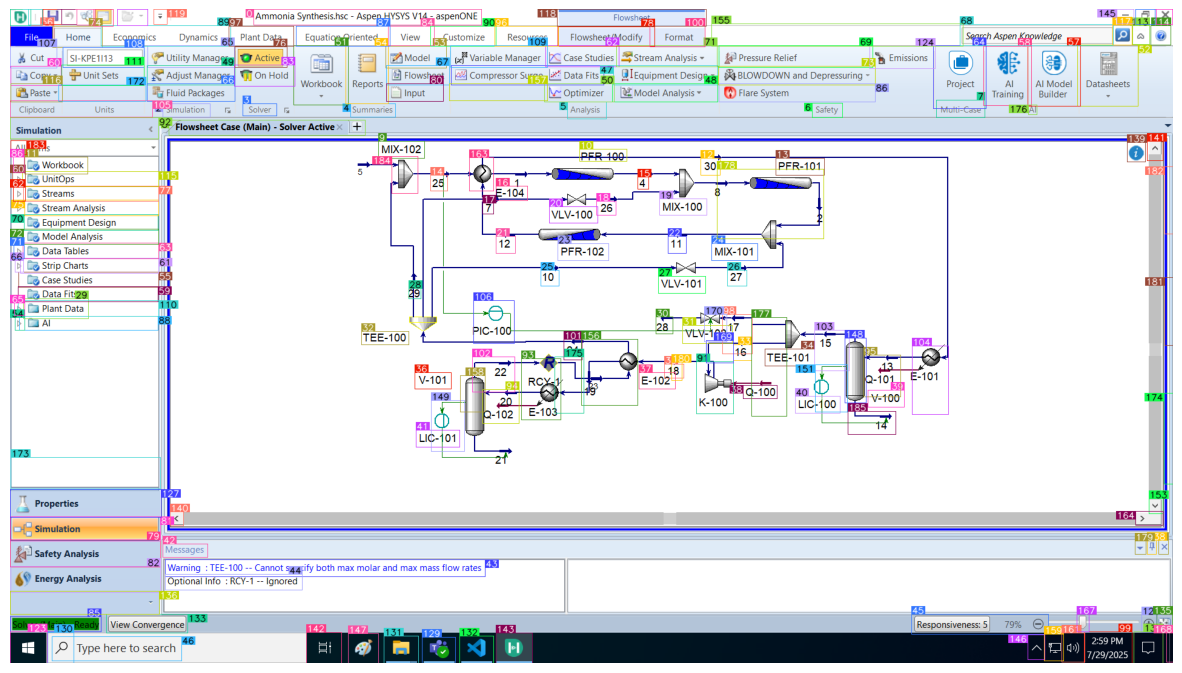

In [6]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [6]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.1500781625509262, 0.011121409013867378, 0.3...",False,Document 10.docx General* Last Modified: Jus...,box_ocr_content_ocr,0
1,text,"[0.034392911940813065, 0.04726598784327507, 0....",False,Home,box_ocr_content_ocr,1
2,text,"[0.22094841301441193, 0.048192769289016724, 0....",False,Mailings,box_ocr_content_ocr,2
3,text,"[0.2595101594924927, 0.05004633963108063, 0.28...",False,Review,box_ocr_content_ocr,3
4,text,"[0.31474727392196655, 0.05004633963108063, 0.3...",False,Help,box_ocr_content_ocr,4
...,...,...,...,...,...,...
123,icon,"[0.9390131235122681, 0.9357990622520447, 0.946...",True,Adding a new item or element.,box_yolo_content_yolo,123
124,icon,"[0.2776850163936615, 0.14850816130638123, 0.28...",True,Paragraph Options,box_yolo_content_yolo,124
125,icon,"[0.31950828433036804, 0.3229212462902069, 0.33...",True,a blank space.,box_yolo_content_yolo,125
126,icon,"[0.08737695962190628, 0.14849500358104706, 0.0...",True,Paragraph Options,box_yolo_content_yolo,126


In [15]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.1500781625509262,
   0.011121409013867378,
   0.3272537887096405,
   0.03521779552102089],
  'interactivity': False,
  'content': 'Document 10.docx  General*  Last Modified: Just now ',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.034392911940813065,
   0.04726598784327507,
   0.05523710325360298,
   0.07228915393352509],
  'interactivity': False,
  'content': 'Home',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.22094841301441193,
   0.048192769289016724,
   0.2542991042137146,
   0.07321593910455704],
  'interactivity': False,
  'content': 'Mailings',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.2595101594924927,
   0.05004633963108063,
   0.2845231890678406,
   0.07136237621307373],
  'interactivity': False,
  'content': 'Review',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.31474727392196655,
   0.05004633963108063,
   0.3335070312023163,
   0.07136237621307373],
  